In [136]:
import os
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, LabelBinarizer
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
df = pl.read_csv('../DATASETS/student_health_data.csv')

In [3]:
df.schema

Schema([('Student_ID', Int64),
        ('Age', Int64),
        ('Gender', String),
        ('Heart_Rate', Float64),
        ('Blood_Pressure_Systolic', Float64),
        ('Blood_Pressure_Diastolic', Float64),
        ('Stress_Level_Biosensor', Float64),
        ('Stress_Level_Self_Report', Float64),
        ('Physical_Activity', String),
        ('Sleep_Quality', String),
        ('Mood', String),
        ('Study_Hours', Float64),
        ('Project_Hours', Float64),
        ('Health_Risk_Level', String)])

In [4]:
# Shape
df.shape

(1000, 14)

In [5]:
# Categorical
categorical_df = df.select(
    pl.col(pl.String())
)
categorical_df

Gender,Physical_Activity,Sleep_Quality,Mood,Health_Risk_Level
str,str,str,str,str
"""M""","""High""","""Moderate""","""Happy""","""Moderate"""
"""F""","""Moderate""","""Good""","""Stressed""","""Moderate"""
"""M""","""Low""","""Moderate""","""Happy""","""Moderate"""
"""M""","""High""","""Poor""","""Happy""","""High"""
"""M""","""Moderate""","""Poor""","""Happy""","""Moderate"""
…,…,…,…,…
"""F""","""Moderate""","""Moderate""","""Stressed""","""Moderate"""
"""F""","""High""","""Poor""","""Happy""","""High"""
"""M""","""Moderate""","""Good""","""Happy""","""Moderate"""


In [6]:
categorical = categorical_df.columns
categorical

['Gender', 'Physical_Activity', 'Sleep_Quality', 'Mood', 'Health_Risk_Level']

In [7]:
# Numerical
numerical_df = df.select(
    pl.col(pl.Int64, pl.Float64)
)
numerical_df

Student_ID,Age,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Study_Hours,Project_Hours
i64,i64,f64,f64,f64,f64,f64,f64,f64
1,24,50.663217,122.173015,84.41986,3.13735,9.028669,34.520973,16.800956
2,21,57.926042,110.778407,75.696145,3.699078,5.819697,16.763846,15.791154
3,22,59.294219,109.375673,83.803814,6.785156,5.89236,44.203798,25.678437
4,24,76.826232,125.142227,78.091587,6.408509,6.884001,21.776645,20.808391
5,20,68.342769,107.515592,80.674937,7.264719,4.48345,8.964999,15.194045
…,…,…,…,…,…,…,…,…
996,23,68.185217,126.031324,69.156288,8.318278,6.841725,30.554113,9.491591
997,18,77.720216,100.627116,75.569051,6.295881,4.15213,29.28585,22.819961
998,24,85.313237,124.362792,91.817614,2.896868,9.253887,15.330941,19.010784


In [8]:
numerical = numerical_df.columns
numerical

['Student_ID',
 'Age',
 'Heart_Rate',
 'Blood_Pressure_Systolic',
 'Blood_Pressure_Diastolic',
 'Stress_Level_Biosensor',
 'Stress_Level_Self_Report',
 'Study_Hours',
 'Project_Hours']

### Mutual info score

In [9]:
pl.Config.set_tbl_rows(20)

polars.config.Config

In [10]:
df_target = df['Health_Risk_Level']

def calculate_mi(series):
    return mutual_info_score(series, df_target)

df_mi = pl.DataFrame({
    col: calculate_mi(df[col])
    for col in numerical + categorical
}).transpose(include_header=True)

df_mi

column,column_0
str,f64
"""Student_ID""",0.855966
"""Age""",0.011361
"""Heart_Rate""",0.834993
"""Blood_Pressure_Systolic""",0.839256
"""Blood_Pressure_Diastolic""",0.841651
"""Stress_Level_Biosensor""",0.855966
"""Stress_Level_Self_Report""",0.855966
"""Study_Hours""",0.850081
"""Project_Hours""",0.855966


### Preprocessing

#### Encoders

In [11]:
le_gender = LabelEncoder()
le_pa = LabelEncoder()
le_sq = LabelEncoder()
le_md = LabelEncoder()
le_target = LabelEncoder()
stds = StandardScaler()
dv = DictVectorizer()

In [13]:
# transform
df_encode = df.with_columns(
    Gender = le_gender.fit_transform(df['Gender']),
    Physical_Activity = le_pa.fit_transform(df['Physical_Activity']),
    Sleep_Quality = le_sq.fit_transform(df['Sleep_Quality']),
    Mood = le_md.fit_transform(df['Mood']),
    Health_Risk_Level = le_target.fit_transform(df['Health_Risk_Level'])
)
df_encode

Student_ID,Age,Gender,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Physical_Activity,Sleep_Quality,Mood,Study_Hours,Project_Hours,Health_Risk_Level
i64,i64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,i64
1,24,1,50.663217,122.173015,84.41986,3.13735,9.028669,0,1,0,34.520973,16.800956,2
2,21,0,57.926042,110.778407,75.696145,3.699078,5.819697,2,0,2,16.763846,15.791154,2
3,22,1,59.294219,109.375673,83.803814,6.785156,5.89236,1,1,0,44.203798,25.678437,2
4,24,1,76.826232,125.142227,78.091587,6.408509,6.884001,0,2,0,21.776645,20.808391,0
5,20,1,68.342769,107.515592,80.674937,7.264719,4.48345,2,2,0,8.964999,15.194045,2
6,22,1,61.744152,90.0,84.450865,4.262518,6.825001,2,0,0,44.948229,15.651195,2
7,22,0,93.097228,106.677782,76.499815,8.415979,1.402915,2,1,0,10.26985,23.818096,2
8,24,0,63.361031,115.396783,70.039502,2.836789,1.486429,1,0,1,39.641788,19.315439,1
9,19,0,81.671029,142.820977,74.676877,5.221367,5.115074,2,1,1,37.211195,8.854986,2


In [14]:
le_gender.classes_, le_md.classes_, le_pa.classes_, le_sq.classes_, le_target.classes_

(array(['F', 'M'], dtype='<U1'),
 array(['Happy', 'Neutral', 'Stressed'], dtype='<U8'),
 array(['High', 'Low', 'Moderate'], dtype='<U8'),
 array(['Good', 'Moderate', 'Poor'], dtype='<U8'),
 array(['High', 'Low', 'Moderate'], dtype='<U8'))

In [15]:
numerical[2:]

['Heart_Rate',
 'Blood_Pressure_Systolic',
 'Blood_Pressure_Diastolic',
 'Stress_Level_Biosensor',
 'Stress_Level_Self_Report',
 'Study_Hours',
 'Project_Hours']

#### Scaler

In [16]:
# Apply StandarScaler to numerical
scaled_data = stds.fit_transform(df.select(numerical[2:]).to_numpy())
scaled_data

array([[-2.03761756,  0.16014487,  0.47371201, ...,  1.43857005,
         0.41543944,  0.39163284],
       [-1.27630635, -0.62046795, -0.43153096, ...,  0.17970871,
        -1.30256737,  0.18496785],
       [-1.13288986, -0.71656535,  0.40978616, ...,  0.20821396,
         1.35225543,  2.20848838],
       ...,
       [ 1.59450216,  0.31016039,  1.24136259, ...,  1.52692154,
        -1.44120136,  0.84389375],
       [ 0.95500203, -0.92245881, -0.27352723, ..., -1.2380128 ,
         0.16390517, -1.17224597],
       [-0.57920864, -0.72351169, -0.33482189, ...,  0.65984122,
         0.06937308,  1.06033108]], shape=(1000, 7))

In [17]:
df_scaled = df_encode.with_columns([
    pl.Series(name, scaled_data[:, i]) for i, name in enumerate(numerical[2:])
])

df_scaled

Student_ID,Age,Gender,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Physical_Activity,Sleep_Quality,Mood,Study_Hours,Project_Hours,Health_Risk_Level
i64,i64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,i64
1,24,1,-2.037618,0.160145,0.473712,-0.904328,1.43857,0,1,0,0.415439,0.391633,2
2,21,0,-1.276306,-0.620468,-0.431531,-0.687847,0.179709,2,0,2,-1.302567,0.184968,2
3,22,1,-1.13289,-0.716565,0.409786,0.50148,0.208214,1,1,0,1.352255,2.208488,2
4,24,1,0.704869,0.363557,-0.182961,0.356327,0.597229,0,2,0,-0.817578,1.21179,0
5,20,1,-0.184394,-0.843994,0.085109,0.686297,-0.344493,2,2,0,-2.057108,0.062764,2
6,22,1,-0.876081,-2.043939,0.476929,-0.470706,0.574083,2,0,0,1.424279,0.156324,2
7,22,0,2.410444,-0.90139,-0.348136,1.129975,-1.55297,2,1,0,-1.930863,1.827753,2
8,24,0,-0.706594,-0.304076,-1.01851,-1.02016,-1.520208,1,0,1,0.91088,0.906244,1
9,19,0,1.212715,1.574679,-0.537298,-0.10118,-0.096711,2,1,1,0.675719,-1.234581,2


In [39]:
df_target = df_scaled['Health_Risk_Level']

#### Mutual Score

In [46]:
# Try MI Score again
df_scaled_mi = pl.DataFrame({
    col: calculate_mi(df_scaled[col])
    for col in numerical[1:] + categorical[:-1]
}).transpose(include_header=True)

df_scaled_mi = df_scaled_mi.rename({"column": "Feature", "column_0": "MI Score"}).sort(by='MI Score', descending=True)
df_scaled_mi

Feature,MI Score
str,f64
"""Stress_Level_Self_Report""",0.855966
"""Stress_Level_Biosensor""",0.855966
"""Project_Hours""",0.855966
"""Study_Hours""",0.850081
"""Blood_Pressure_Diastolic""",0.841651
"""Blood_Pressure_Systolic""",0.839256
"""Heart_Rate""",0.834993
"""Physical_Activity""",0.035409
"""Sleep_Quality""",0.021906


- **Physiological Data**: Real-time biosensor metrics, including heart rate, blood pressure (systolic and diastolic), and stress levels, collected to gauge physical health.
- **Psychological Data**: Self-reported stress levels and mood states, providing insight into students' mental and emotional well-being.

> **Health Risk Level**: A target label indicating low, moderate, or high health risk, derived from combinations of physiological and psychological metrics.

In [ ]:
# Drop Columns
df_scaled = df_scaled.drop("Student_ID")
df_scaled

#### Split data

In [51]:
# Split data
df_train_full, df_test = train_test_split(df_scaled, test_size=0.2, shuffle=True, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

In [52]:
len(df_scaled), len(df_train), len(df_test), len(df_val)

(1000, 600, 200, 200)

In [53]:
# Train
x_train = df_train.select(pl.exclude(["Student_ID", "Health_Risk_Level", "Physical_Activity", "Sleep_Quality", "Age", "Mood", "Gender"]))
x_train = x_train.to_dicts()
x_train = dv.fit_transform(x_train)
x_train = csr_matrix(x_train)
# Target
y_train = df_train['Health_Risk_Level']

In [54]:
# Validation
x_val = df_val.select(pl.exclude(["Student_ID", "Health_Risk_Level", "Physical_Activity", "Sleep_Quality", "Age", "Mood", "Gender"]))
x_val = x_val.to_dicts()
x_val = dv.transform(x_val)
x_val = csr_matrix(x_val)
# Target
y_val = df_val['Health_Risk_Level']

In [55]:
# Test
x_test = df_test.select(pl.exclude(["Student_ID", "Health_Risk_Level", "Physical_Activity", "Sleep_Quality", "Age", "Mood", "Gender"]))
x_test = x_test.to_dicts()
x_test = dv.transform(x_test)
x_test = csr_matrix(x_test)
# Target
y_test = df_test['Health_Risk_Level']

### Train models

#### LogisticRegression

In [57]:
lr_model = LogisticRegression(random_state=42, solver='newton-cholesky')

In [58]:
lr_model.fit(x_train, y_train)

LogisticRegression(random_state=42, solver='newton-cholesky')

In [59]:
# Test predict
y_pred_test = lr_model.predict(x_test)
y_pred_val = lr_model.predict(x_val)

In [97]:
# confusion matrix
cf_matrix_test = confusion_matrix(y_test, y_pred_test)
cf_matrix_val = confusion_matrix(y_val, y_pred_val)

cf_matrix_test, cf_matrix_val

(array([[  7,   2,  23],
        [  0,  36,  11],
        [  0,   2, 119]]),
 array([[ 14,   1,  11],
        [  0,  21,   5],
        [  0,   8, 140]]))

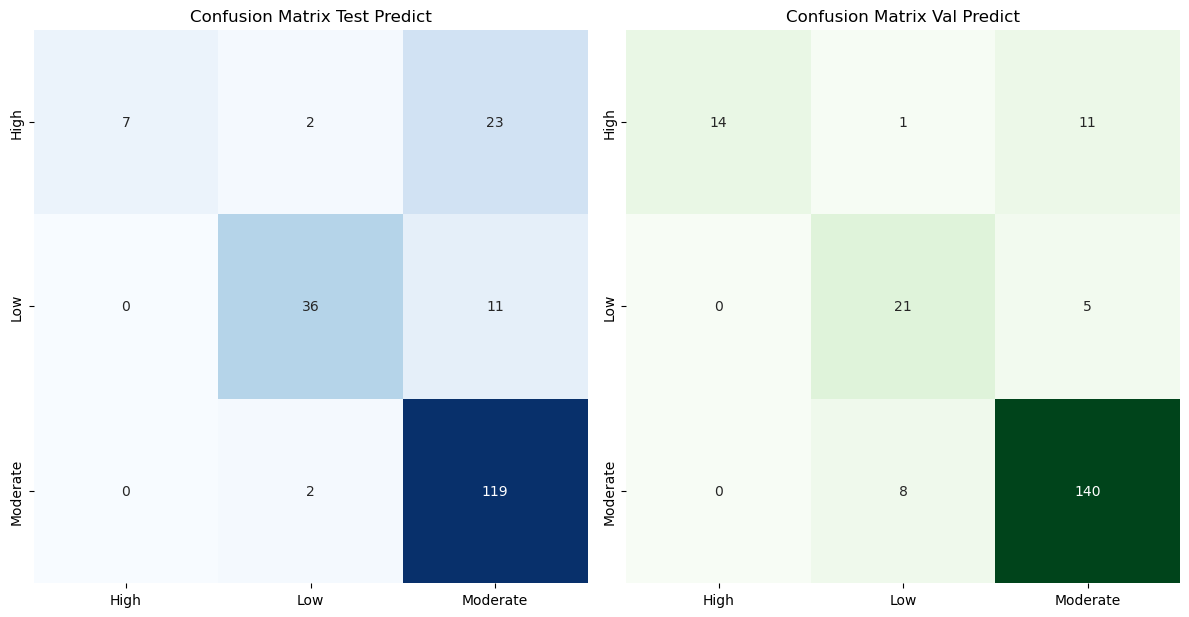

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

classes = le_target.inverse_transform(df_target.unique().to_list())
g = sns.heatmap(cf_matrix_test, cmap='Blues', annot=True, fmt="d", cbar=False, ax=ax[0], square=True, xticklabels=classes, yticklabels=classes)
g.set(title="Confusion Matrix Test Predict")

h = sns.heatmap(cf_matrix_val, cmap='Greens', annot=True, fmt="d", cbar=False, ax=ax[1], square=True, xticklabels=classes, yticklabels=classes)
h.set(title="Confusion Matrix Val Predict")
plt.tight_layout()
plt.show()

In [125]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.22      0.36        32
           1       0.90      0.77      0.83        47
           2       0.78      0.98      0.87       121

    accuracy                           0.81       200
   macro avg       0.89      0.66      0.69       200
weighted avg       0.84      0.81      0.78       200



In [126]:
print(classification_report(y_val, y_pred_val))


              precision    recall  f1-score   support

           0       1.00      0.54      0.70        26
           1       0.70      0.81      0.75        26
           2       0.90      0.95      0.92       148

    accuracy                           0.88       200
   macro avg       0.87      0.76      0.79       200
weighted avg       0.89      0.88      0.87       200



In [127]:
root_mean_squared_error(y_test, y_pred_test), root_mean_squared_error(y_val, y_pred_val)


(0.7314369419163897, 0.5385164807134504)

#### RandomForestClassifier

In [128]:
# RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [129]:
y2_pred_test = rfc.predict(x_test)
y2_pred_val = rfc.predict(x_val)

In [130]:
print(classification_report(y_test, y2_pred_test))
print(classification_report(y_val, y2_pred_val))

              precision    recall  f1-score   support

           0       1.00      0.56      0.72        32
           1       0.94      0.98      0.96        47
           2       0.91      1.00      0.95       121

    accuracy                           0.93       200
   macro avg       0.95      0.85      0.88       200
weighted avg       0.93      0.93      0.92       200

              precision    recall  f1-score   support

           0       0.95      0.73      0.83        26
           1       0.96      1.00      0.98        26
           2       0.96      0.99      0.98       148

    accuracy                           0.96       200
   macro avg       0.96      0.91      0.93       200
weighted avg       0.96      0.96      0.96       200



In [131]:
root_mean_squared_error(y_test, y2_pred_test), root_mean_squared_error(y_val, y2_pred_val)

(0.4898979485566356, 0.3807886552931954)

#### RandomForestRegressor

In [132]:
# RandomForest
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=42, n_jobs=-1)
rfr.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=42)

In [142]:
y3_pred_test = rfr.predict(x_test)
y3_pred_val = rfr.predict(x_val)

In [143]:
root_mean_squared_error(y_test, y3_pred_test), root_mean_squared_error(y_val, y3_pred_val)

(0.5012983143797713, 0.41629316592997295)

#### SVC

In [137]:
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(x_train, y_train)

SVC(kernel='linear', random_state=42)

In [140]:
y4_pred_test = svm.predict(x_test)
y4_pred_val = svm.predict(x_val)

In [141]:
print(classification_report(y_test, y4_pred_test))
print(classification_report(y_val, y4_pred_val))

              precision    recall  f1-score   support

           0       0.90      0.28      0.43        32
           1       0.90      0.81      0.85        47
           2       0.80      0.98      0.88       121

    accuracy                           0.82       200
   macro avg       0.87      0.69      0.72       200
weighted avg       0.84      0.82      0.80       200

              precision    recall  f1-score   support

           0       0.93      0.54      0.68        26
           1       0.64      0.81      0.71        26
           2       0.89      0.92      0.91       148

    accuracy                           0.85       200
   macro avg       0.82      0.76      0.77       200
weighted avg       0.87      0.85      0.85       200



### Model Scores

In [149]:
models = [lr_model, rfc, rfr, svm]
models_names = ["LogisticRegression", "RandomForestClassifier", "RandomForestRegressor", "SVC"]

# Scores
train_score = [model.score(x_train, y_train) for model in models]
test_score = [model.score(x_test, y_test) for model in models]
val_score = [model.score(x_val, y_val) for model in models]

# Measure model state
rate = []
for train, test, val in zip(train_score, test_score, val_score):
    if train <= 0.65 and test <= 0.65 and val <= 0.65:
        rate.append('bad')
    elif (train > 0.65 and train < 0.80) and (test > 0.65 and test < 0.80) and (val > 0.65 and val < 0.80):
        rate.append('middle')
    elif (train >= 0.80 and test >= 0.80 and val >= 0.80) and (train <= 0.999 and test <= 0.999 and val <= 0.999):
        rate.append('good') 
    else:
        rate.append('overfite')  # Handle cases that don't fit the above

In [150]:
# Create DataFrame
model_score = pl.DataFrame({
    'Model': models_names,
    'Train score': [f'{round(score * 100, 2)}%' for score in train_score],
    'Test score': [f'{round(score * 100, 2)}%' for score in test_score],
    'Val score': [f'{round(score * 100, 2)}%' for score in val_score],
    'Evaluate model': rate
})

# Show result:
model_score

Model,Train score,Test score,Val score,Evaluate model
str,str,str,str,str
"""LogisticRegression""","""88.17%""","""81.0%""","""87.5%""","""good"""
"""RandomForestClassifier""","""99.83%""","""92.5%""","""96.0%""","""good"""
"""RandomForestRegressor""","""95.21%""","""55.68%""","""65.19%""","""overfite"""
"""SVC""","""87.67%""","""82.5%""","""85.5%""","""good"""


### Saving models

In [151]:
def dump_pickle(obj, filename: str):
    with open(filename, "wb") as f_out:
        return pickle.dump(obj, f_out)

In [152]:
# Select best models
for row in model_score.filter(pl.col("Evaluate model") == "good").iter_rows():
    print(row[0])

LogisticRegression
RandomForestClassifier
SVC


> We can save three models, if we check the dataframe, RFC model has better results. Only for testing, I will save three models.

In [153]:
dest_path = '../models'

for row in tqdm(model_score.filter(pl.col("Evaluate model") == "good").iter_rows()):
        model_name = row[0]
        idx = models_names.index(model_name)
        model = models[idx]
        dump_pickle(model, os.path.join(dest_path, f"{model_name}.pkl"))

0it [00:00, ?it/s]

In [154]:
# Save enconder and scaler
dump_pickle(le_gender, os.path.join(dest_path, "gender_encoder.bin"))
dump_pickle(le_md, os.path.join(dest_path, "mood_encoder.bin"))
dump_pickle(le_sq, os.path.join(dest_path, "sleep_quality_encoder.bin"))
dump_pickle(le_pa, os.path.join(dest_path, "phisical_activity_encoder.bin"))
dump_pickle(le_target, os.path.join(dest_path, "health_risk_level_encoder.bin"))
dump_pickle(stds, os.path.join(dest_path, "standard_scaler.bin"))
dump_pickle(dv, os.path.join(dest_path, "dv.bin"))

In [159]:
df_train.select(pl.exclude(["Student_ID", "Health_Risk_Level", "Physical_Activity", "Sleep_Quality", "Age", "Mood", "Gender"])).columns

['Heart_Rate',
 'Blood_Pressure_Systolic',
 'Blood_Pressure_Diastolic',
 'Stress_Level_Biosensor',
 'Stress_Level_Self_Report',
 'Study_Hours',
 'Project_Hours']

### Load model

In [211]:
import pickle as pkl
import json
# Load model
model_name = "RandomForestClassifier"
with open(f"../models/{model_name}.pkl", "rb") as f:
    model = pkl.load(f)

# Load Scaler
with open("../models/standard_scaler.bin", "rb") as f:
    scaler = pkl.load(f)

# Load Label
with open("../models/health_risk_level_encoder.bin", "rb") as f:
    le_target = pkl.load(f)

# Load DV
with open("../models/dv.bin", "rb") as f:
    dv = pkl.load(f)

In [182]:
model, scaler, le_target, dv

(RandomForestClassifier(n_estimators=10, random_state=42),
 StandardScaler(),
 LabelEncoder(),
 DictVectorizer())

In [176]:
with open('../student-health-predictor-service/test/sample_low.json', 'rt', encoding='utf-8') as f_in:
        data1 = json.load(f_in)

with open('../student-health-predictor-service/test/sample_high.json', 'rt', encoding='utf-8') as f_in:
        data2 = json.load(f_in)

with open('../student-health-predictor-service/test/sample_moderate.json', 'rt', encoding='utf-8') as f_in:
        data3 = json.load(f_in)

In [226]:
data2

{'Heart_Rate': 66.99859715607509,
 'Blood_Pressure_Systolic': 128.10036347425384,
 'Blood_Pressure_Diastolic': 79.80531300922902,
 'Stress_Level_Biosensor': 8.679854679999274,
 'Stress_Level_Self_Report': 1.4651711192001864,
 'Study_Hours': 22.17242991120623,
 'Project_Hours': 8.313787920405774,
 'Health_Risk_Level': 'High'}

#### Test one element

In [227]:
# Prepare
columns = list(data2.keys())[:-1]
# print(columns)
patient = pl.DataFrame([data2]).drop("Health_Risk_Level")
print(patient)
# Scaler
scaled_data = scaler.transform(patient.to_numpy())
print(scaled_data)

shape: (1, 7)
┌────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ Heart_Rate ┆ Blood_Pressu ┆ Blood_Pressu ┆ Stress_Leve ┆ Stress_Leve ┆ Study_Hours ┆ Project_Hou │
│ ---        ┆ re_Systolic  ┆ re_Diastolic ┆ l_Biosensor ┆ l_Self_Repo ┆ ---         ┆ rs          │
│ f64        ┆ ---          ┆ ---          ┆ ---         ┆ rt          ┆ f64         ┆ ---         │
│            ┆ f64          ┆ f64          ┆ f64         ┆ ---         ┆             ┆ f64         │
│            ┆              ┆              ┆             ┆ f64         ┆             ┆             │
╞════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 66.998597  ┆ 128.100363   ┆ 79.805313    ┆ 8.679855    ┆ 1.465171    ┆ 22.17243    ┆ 8.313788    │
└────────────┴──────────────┴──────────────┴─────────────┴─────────────┴─────────────┴─────────────┘
[[-0.32529371  0.56621099 -0.00513059  1.23166827 -1.528547   -0.77928542
  -

In [228]:
patient = patient.with_columns([
    pl.Series(name, scaled_data[:, i]) for i, name in enumerate(columns)
])
patient

Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Study_Hours,Project_Hours
f64,f64,f64,f64,f64,f64,f64
-0.325294,0.566211,-0.005131,1.231668,-1.528547,-0.779285,-1.345342


In [229]:
X = patient
X = X.to_dicts()
X = dv.transform(X)
X = csr_matrix(X)
y_pred = model.predict(X)
str(le_target.inverse_transform(y_pred)[0])

'High'

#### Adapt to Functions

In [243]:
def prepare_data(patient) -> pl.DataFrame:
    # Prepare
    columns = list(patient.keys())[:-1]
    patient = pl.DataFrame([patient]).drop("Health_Risk_Level")
    # Scaler
    scaled_data = scaler.transform(patient.to_numpy())

    patient = patient.with_columns([
        pl.Series(name, scaled_data[:, i]) for i, name in enumerate(columns)
    ])

    return patient

In [245]:
def predict_single(patient) -> str:
    X = prepare_data(patient)
    # print(X)
    X = X.to_dicts()
    X = dv.transform(X)
    X = csr_matrix(X)
    y_predict = model.predict(X)
    return str(le_target.inverse_transform(y_predict)[0])

In [246]:
for p in tqdm([data1, data2, data3]):
    result = predict_single(p)
    print(result)

  0%|          | 0/3 [00:00<?, ?it/s]

Low
High
Moderate
